## Import packages

In [33]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt
# force inline plots
%matplotlib inline
import torch 
# import pymc3 as pm

#  a function to load and save results
import joblib as jb

In [34]:
# update fonts
FONTSIZE = 18
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)

## Generate parameters and data for target 0 (the fake data). 

The data is simulated here by first solving the differential equations for the SIR model and then sampling at each time point from a Poisson distribution with mean equal to the differntial equation solution I(t). 

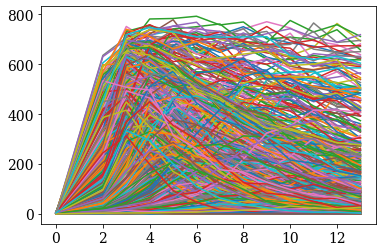

In [51]:
# %run /Users/fermi/Dropbox/projects/SIRLikelihood/SIR_ODE.ipynb
# %run /Users/fermi/Dropbox/projects/SIRLikelihood//SIR_simulator.ipynb
%run /content/SIRLikelihood/SIR_ODE.ipynb
%run /content/SIRLikelihood/SIR_simulator.ipynb


sampleMax = 50000
alpha = 0.465 #.1;d
beta = 0.00237 #.0002;
tdata0 = np.array([1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]) -1 


alphaRange = [alpha*0.01,alpha*1.99]
betaRange = [beta*0.01,beta*1.99]
s0mean = 763; #763 - boarding school value
i0mean = 3;
r0mean = 0;
init_mean = np.array([s0mean,i0mean,r0mean])

def generateTarget0(par,init_mean,t):
    #set initial conditions 
    MS.init_cond = init_mean;
    MS.t_eval = t
    # Solve the model with parmaters par.
    eps = 1e-4
    alpha = par[0]
    beta = par[1]
    #solve ODE equation and return solutions for s,i,r populations time series data
    soln = SolveSIRModel(alpha,beta)
    # Extract ODE solutions Imean=I(t) and the times t.
    t = soln.t
    Imean = soln.y[1]
    #make sure all values for the infected time series data are positive 
    Imean[Imean<0] = eps
    #sample from a poisson distribution with mean equal to the ODE solution for the infected populations 
    sim_dat = np.random.poisson(Imean)
    return t, sim_dat

def plotData(data,index):
    dim = data.shape[0]
    if index > dim:
        index = dim
    for i in range(0,index):
        plt.plot(data[i][0],data[i][1])
    return

def generate_class0(init_mean,alphaRange,betaRange,sampleMax,dataLabel = 'target0_parData'):
    parameters_list = []
    data_list = []
    for i in range(0,sampleMax):
        #sample alpha and beta from prior distribution
        alphaSample = np.random.uniform(alphaRange[0],alphaRange[1])
        betaSample = np.random.uniform(betaRange[0],betaRange[1])
        #sample data using generate_target0
        [t, I] = generateTarget0([alphaSample,betaSample],init_mean,tdata0)
        #print(I, np.shape(I),type(I))
        #append data to dataframe
        #target0_df = target0_df.append({'s0': s0mean,'i0': i0mean, 'r0': r0mean, 'alpha':  alphaSample,'beta': betaSample, 'time': t, 'Infected': I},ignore_index=True)
        #target0_df.to_csv('target0_data.csv',index=False)

        parameters_list.append(np.asarray([s0mean,i0mean,r0mean,alphaSample,betaSample]))
        data_list.append(np.asarray([t,I]))
    parameters = np.asarray(parameters_list)
    data = np.asarray(data_list)
        #target0_df.to_pickle("target0_data.pkl")

    
    jb.dump([parameters,data],dataLabel)

    plotData(data,1000)
    return [parameters , data]

[parameters0 , data0] = generate_class0(init_mean,alphaRange,betaRange,sampleMax)

## Generate parameters and data for target 1 (the real data). 

The "real" data is simulated using a Continuous-Time Markov Chain (CTMC) analog of the SIR ODE model. The generated output is discretized to a time-step of 1 day.

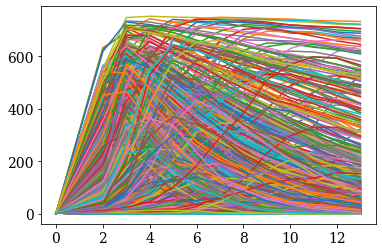

In [52]:
tdata0 = np.array([1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]) -1 
ydata0 = np.array([3, 25, 75, 227, 296, 258, 236, 192, 126, 71, 28, 11, 7])

#data is transposed somehoe from whjat I intend ed form the infected data sets as compared to target0
T = tdata0
tmin = T[0];
tmax = T[-1] 
maxiter = 50000;
#initial conditions are the same for both targets 

def generate_class1(T,tmin,tmax,maxiter,init_mean,alphaRange,betaRange,sampleMax,dataLabel = 'target1_parData'):
    parameters_list  = []
    data_list = []

    for j in range(0,sampleMax):
        #iLengthened needs to be initialized inside the for loop. Not sure why. But if I have it 
        # initialized outside the for loop only the last entry is appended to the dataframe
        iLengthened = np.empty((tmax))
        iLengthened[:]= 0

        #randomly initialize the initial conditions for the SIR simulations 
        # s0 = np.random.poisson(s0mean);
        # i0 = np.random.poisson(i0mean);
        # r0 = np.random.poisson(r0mean);

        #sample from a uniform prior for the alpha (the recovery rate) and beta (the infection rate) parameters 
        alphaSample = np.random.uniform(alphaRange[0],alphaRange[1])
        betaSample = np.random.uniform(betaRange[0],betaRange[1])
        # generate susceptable, infected and recovered populations from a continuous time markov chain simulation.
        [s,i,r] = generateTarget1(T, s0mean, i0mean, r0mean, tmin, tmax, alphaSample, betaSample,maxiter)
        #write over the first np.size(i) entries of iLengthened with the synthetic data i. This guarantees that the 
        #infected population data iLengthened will have length of tmax with all other entries being NAN values.
        iLengthened[0:np.size(i)] = i
        #print(iLengthened, np.shape(iLengthened),type(iLengthened))
        #append data to targer1 dataframe
        #target1_df = target1_df.append({'s0': s0mean,'i0': i0mean, 'r0': r0mean, 'alpha':  alphaSample,'beta': betaSample, 'time': T, 'Infected': iLengthened},ignore_index=True)
        #target1_df.to_csv('target1_data.csv',index=False)
        #save dataframe as a compressed filed (pkl)
        #target1_df.to_pickle("target1_data.pkl")

        parameters_list.append(np.asarray([s0mean,i0mean,r0mean,alphaSample,betaSample]))
        data_list.append(np.asarray([t,iLengthened]))

    parameters = np.asarray(parameters_list)
    data = np.asarray(data_list)

    # save data
    jb.dump([parameters,data],dataLabel)

    #plot data
    plotData(data,1000)
    return [parameters , data]

[parameters1 , data1] = generate_class1(T,tmin,tmax,maxiter,init_mean,alphaRange,betaRange,sampleMax)

In [48]:
# 80% for training data set (validation 30%, training 50%), 20% for testing (50,000 datasets for target 1 and target 0) 
# I do resnet
# Ali does a 1D convolution network , and standard deep neural network
# 
par0, data0 = jb.load('target0_parData')
par1, data1 = jb.load('target1_parData')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b323b509-75b9-423f-bb04-ac84a2ad5053' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>